# Prepare Data & Feature Engineering

## Project Description

The MoneyBall project give two labelled datasets of successful and unsuccessful companies. One of the features lists the name of all VC investors. Midas is a previous project at Vela that ranked VC investors that invested with a fixed set of "brand-name" investors. Aim of the project will be to add the investor ranking as an additional feature of the MoneyBall project dataset and its effect on classification. If there's time combining these results with the beast feature identified from previous interns work to further inmprove the model accuracy.

In [924]:
import copy, datetime, difflib, json, math
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
from itertools import permutations
from IPython.display import display, HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5] 

# MoneyBall Data Loading

In [925]:
base_path = '/Users/tejmoxham/Documents/Projects/vela_partners/'
sheets = ['List', 'Academic', 'Work', 'Investor'] # Ignore Description sheet

In [932]:
# Successful companies

# File path
sxls_path = base_path+'/data/moneyball_raw/latest_successful_companies_moneyball_internship_data.xlsx'

# Load data into pandas dataframe
sxls = pd.ExcelFile(sxls_path)
sdf = pd.read_excel(sxls, sheets[0], index_col='name')
for sheet in sheets[1:]:
    df = pd.read_excel(sxls, sheet, index_col='name')
    sdf = pd.merge(sdf, df, on='name', how='left')
    
# Drop duplicate rows
sdf = sdf[~sdf.index.duplicated(keep='first')] 

# Add the success label
sdf['success'] = 1

# Display the successful MoneyBall dataframe head
print('Successful MoneyBall Dataframe Shape:', sdf.shape)
display(HTML(sdf.head(n=1).to_html())) # Display the successful dataframe head

Successful MoneyBall Dataframe Shape: (2175, 16)


,domain,founded_year,city,category_list,category_groups_list,short_description,success_type,universities_of_founders,degrees_of_founders,subject_degrees_of_founders,gender_of_founders,city_of_founders,prev_companies_of_founders,prev_title_of_founders,investor_name,success
name,,,,,,,,,,,,,,,,
Lordstown Motors,lordstownmotors.com,2019.0,Warren,"Automotive,Electric Vehicle,Industrial,Manufacturing","Manufacturing,Transportation",Lordstown Motors is an automotive company that develops and manufactures light-duty electric trucks.,ipo,NaN,NaN,NaN,NaN,NaN,Lordstown Motors,Founder & Chief Executive Officer,NaN,1


In [933]:
# Unsuccessful companies

# File path
uxls_path = base_path+'/data/moneyball_raw/unsuccessful_companies_moneyball_internship_data.xlsx'

# Load data into pandas dataframe
uxls = pd.ExcelFile(uxls_path)
udf = pd.read_excel(uxls, sheets[0], index_col='name')
for sheet in sheets[1:]:
    df = pd.read_excel(uxls, sheet, index_col='name')
    udf = pd.merge(udf, df, on='name', how='left')
    
# Drop duplicate rows
udf = udf[~udf.index.duplicated(keep='first')] 

# Add the success label
udf['success'] = 0

# Display the unsuccessful MoneyBall dataframe head
print('Unsuccessful MoneyBall Dataframe Shape:', udf.shape)
display(HTML(udf.head(n=1).to_html())) # Display the successful dataframe head

Unsuccessful MoneyBall Dataframe Shape: (42777, 14)


,founded_year,country_code,city,category_list,category_groups_list,universities_of_founders,degrees_of_founders,subject_degrees_of_founders,gender_of_founders,city_of_founders,prev_companies_of_founders,prev_title_of_founders,investor_name,success
name,,,,,,,,,,,,,,
BitMethod,2009.0,USA,Des Moines,"Android,iOS,Mobile","Mobile,Platforms,Software",Iowa State University,BS,Computer Science,male,NaN,"BitMethod,BitMethod","Founder, CEO,Founder, Senior Software Engineer",NaN,0


Combine dataframes, remove unnecessary data which will definetly not be used and include domain, founded year, country code, city

In [934]:
# Successful features to be removed
successful_remove_columns = ['prev_title_of_founders', 'city_of_founders', 'gender_of_founders', 'subject_degrees_of_founders', 'degrees_of_founders', 'category_list', 'category_groups_list', 'founded_year', 'city', 'domain', 'short_description', 'success_type']
sdf = sdf.drop(columns=successful_remove_columns)

# Unsuccessful features to be removed
unsuccessful_remove_columns = ['prev_title_of_founders', 'city_of_founders', 'gender_of_founders', 'subject_degrees_of_founders', 'degrees_of_founders', 'category_list', 'category_groups_list', 'founded_year', 'city', 'country_code']
udf = udf.drop(columns=unsuccessful_remove_columns)

# Combine the successful and unsuccessful dataframes
df0 = pd.concat([sdf, udf])

# Find duplicate company entries and append dp to index
df0.index = df0.index.map(str)
df0.index = df0.index.where(~df0.index.duplicated(), df0.index+'_dp')

# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df0.shape)
display(HTML(df0.head(n=1).to_html())) 

Combined MoneyBall Dataframe Shape: (44952, 4)


,universities_of_founders,prev_companies_of_founders,investor_name,success
name,,,,
Lordstown Motors,NaN,Lordstown Motors,NaN,1


# Previous Company of Founders

In [1095]:
# Local copy of main dataframe
df1 = copy.deepcopy(df0)

# Convert previous companies to list object
df1['prev_companies_of_founders'] = df1['prev_companies_of_founders'].replace(np.nan, '')
df1['prev_companies_of_founders'] = df1['prev_companies_of_founders'].apply(lambda x: list(x.split(',')) if type(x)==str else [])

# Remove name if it appears in the previous companies
updated_prev_companies_of_founders = {}
for index, row in list(df1.iterrows()):
    update_prev_companies_of_founders_row = row['prev_companies_of_founders']
    if index in row['prev_companies_of_founders']:
        update_prev_companies_of_founders_row[:] = [x for x in update_prev_companies_of_founders_row if x != index]
    updated_prev_companies_of_founders[index] = update_prev_companies_of_founders_row
df1['prev_companies_of_founders'] = pd.Series(updated_prev_companies_of_founders)

# Convert previous companies to list object
prev_companies_of_founders = [item for sublist in df1['prev_companies_of_founders'].values for item in sublist]
prev_companies_of_founders = [x for x in prev_companies_of_founders if x!='']
prev_companies_of_founders_set = list(set(prev_companies_of_founders))

# Count the number of occurences of a unique company
prev_companies_of_founders_count = [[0, x] for x in prev_companies_of_founders_set]
for company in prev_companies_of_founders:
    idx = prev_companies_of_founders_set.index(company)
    prev_companies_of_founders_count[idx][0] += 1
prev_companies_of_founders_count.sort(reverse=True)

# Remove Inc., Inc and LLC
remove_list = [' Inc.', ' Inc', ' LLC']
for idx, value in enumerate(prev_companies_of_founders_count):
    if value[1] in remove_list:
        del prev_companies_of_founders_count[idx]

# Display the top ten most occurences
for idx, value in enumerate(prev_companies_of_founders_count[:10]):
    print('The top {} most popular previous company of founders is {} occuring {} times'.format(idx+1, value[1], value[0] ))

The top 1 most popular previous company of founders is Google occuring 598 times
The top 2 most popular previous company of founders is Microsoft occuring 439 times
The top 3 most popular previous company of founders is Meta occuring 196 times
The top 4 most popular previous company of founders is Yahoo occuring 181 times
The top 5 most popular previous company of founders is Apple occuring 173 times
The top 6 most popular previous company of founders is Techstars occuring 147 times
The top 7 most popular previous company of founders is IBM occuring 134 times
The top 8 most popular previous company of founders is Oracle occuring 124 times
The top 9 most popular previous company of founders is Accenture occuring 113 times
The top 10 most popular previous company of founders is Cisco occuring 111 times


Generate a feature column for the top 10 most popular previous companies

In [1127]:
# Top popular threshold
top_thresh = 10

# Local copy of main dataframe
df2 = copy.deepcopy(df1)

top_prev_comp = prev_companies_of_founders_count[:top_thresh]
top_prev_comp_count, top_prev_comp_names = zip(*top_prev_comp)

# Count the successful occurences of each company
top_prev_comp_success = [0]*len(top_prev_comp_names)
for index, row in list(df2.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if (comp in top_prev_comp_names) and (row['success']==1): 
            top_prev_comp_success[top_prev_comp_names.index(comp)] += 1

# Add column to dataframe
df2.insert(df2.columns.get_loc('prev_companies_of_founders')+1, 'top_popular_prev_comp_flag', 0)
for index, row in list(df2.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if comp in top_prev_comp_names: 
            df2.at[index, 'top_popular_prev_comp_flag'] = 1

# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df2.shape)
display(HTML(df2.head(n=1).to_html()))         

Combined MoneyBall Dataframe Shape: (44952, 5)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,investor_name,success
name,,,,,
Lordstown Motors,NaN,[],0,NaN,1


Generate a feature column for the top 10 most successful previous companies, with at least 50 previous employees

In [1143]:
# Top success threshold
min_prev_employees = 25
success_thresh = 0.5

# Local copy of main dataframe
df3 = copy.deepcopy(df2)

# Find companies with the minimum number of employees
top_prev_comp_count, top_prev_comp_names = zip(*prev_companies_of_founders_count)
top_prev_indx = np.where(np.array(top_prev_comp_count)>min_prev_employees)
top_prev_comp_count, top_prev_comp_names = zip(*prev_companies_of_founders_count[:top_prev_indx[0][-1]])

# Count the successful occurences of each company
top_prev_comp_success = [0]*len(top_prev_comp_names)
for index, row in list(df3.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if (comp in top_prev_comp_names) and (row['success']==1): 
            top_prev_comp_success[top_prev_comp_names.index(comp)] += 1
top_prev_comp_success, top_prev_comp_count = np.array(top_prev_comp_success), np.array(top_prev_comp_count)
top_prev_comp_rate = top_prev_comp_success/top_prev_comp_count


# Add column to dataframe
df3.insert(df3.columns.get_loc('top_popular_prev_comp_flag')+1, 'top_success_prev_comp_flag', 0)
for index, row in list(df3.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if (comp in top_prev_comp_names): 
            if (top_prev_comp_rate[top_prev_comp_names.index(comp)]>success_thresh): 
                df3.at[index, 'top_success_prev_comp_flag'] = 1

# Display the top ten most probable      
tmp_zip = list(zip(top_prev_comp_rate, top_prev_comp_names))
tmp_zip = sorted(tmp_zip)[::-1]
for idx, value in enumerate(tmp_zip[:11]):
    print('The top {} most successful previous company of founders is {} with {} success'.format(idx+1, value[1], value[0] ))
    
# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df3.shape)
display(HTML(df3.head(n=1).to_html())) 

The top 1 most successful previous company of founders is Seres Therapeutics with 1.0 success
The top 2 most successful previous company of founders is Joule Unlimited Technologies with 1.0 success
The top 3 most successful previous company of founders is Axcella with 1.0 success
The top 4 most successful previous company of founders is Flagship Pioneering with 0.9166666666666666 success
The top 5 most successful previous company of founders is  San Francisco with 0.7931034482758621 success
The top 6 most successful previous company of founders is Harvard Medical School with 0.7884615384615384 success
The top 7 most successful previous company of founders is Harvard Business School with 0.7142857142857143 success
The top 8 most successful previous company of founders is Genentech with 0.6923076923076923 success
The top 9 most successful previous company of founders is Tesla with 0.5714285714285714 success
The top 10 most successful previous company of founders is Massachusetts Institut

,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,investor_name,success
name,,,,,,
Lordstown Motors,NaN,[],0,0,NaN,1


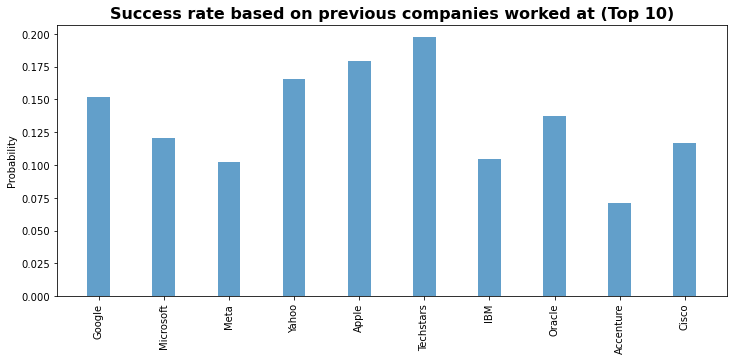

In [1118]:
top_thresh = 10
#print('Succes Rate:', list(top_prev_comp_rate[:top_thresh]))
#print('Company Names:', list(top_prev_comp_names[:top_thresh]))
plt.title('Success rate based on previous companies worked at (Top 10)', fontsize=16, fontweight='bold')
plt.bar(range(0, top_thresh), top_prev_comp_rate[:top_thresh], 0.35, alpha=0.7,)
plt.ylabel('Probability')
plt.xticks(range(0, top_thresh), top_prev_comp_names[:top_thresh])
plt.xticks(rotation=90)
plt.show()

Generate feature column where founders have worked at a previous MoneyBall company and whether it was successful or not.

In [1147]:
# Local copy of main dataframe
df4 = copy.deepcopy(df3)

# Find previous companies within the MoneyBall dataset and whether they were successful/uncussessful
moneymall_prev_comp_success = {}
moneyball_prev_comps_count = 0
moneyball_all_comps = df4.index.values.tolist()

success_moneyball_companies = []
for index, row in list(df4.iterrows()):
    
    # Check if previous companies is in MoneyBall
    moneymall_prev_comp_success_cell = 0
    for comp in row['prev_companies_of_founders']:
        
        if comp in moneyball_comps: 
            success_moneyball_companies.append(comp)
            # previous company success
            if df4.loc[comp]['success']==1:
                
                moneymall_prev_comp_success_cell += 1
            elif df4.loc[comp]['success']==0:
                moneymall_prev_comp_success_cell -= 1
            moneyball_prev_comps_count += 1
    
    # Categorising between -1, 0, 1
    if moneymall_prev_comp_success_cell>0:
        moneymall_prev_comp_success_cell = 1
    elif moneymall_prev_comp_success_cell<0:
        moneymall_prev_comp_success_cell = -1
    else:
        moneymall_prev_comp_success_cell = 0
        
    # Update new column values
    moneymall_prev_comp_success[index] = moneymall_prev_comp_success_cell

print(len(set(success_moneyball_companies)))

# Insert row 
df4.insert(df4.columns.get_loc('top_success_prev_comp_flag')+1, 'moneyball_prev_comp_success', pd.Series(moneymall_prev_comp_success))

# Display the combined MoneyBall dataframe head
print('Number of occurences of a founder working for a previous MoneyBall company:', moneyball_prev_comps_count)
print('Combined MoneyBall Dataframe Shape:', df4.shape)
display(HTML(df4.head(n=1).to_html())) 

2608
Number of occurences of a founder working for a previous MoneyBall company: 5927
Combined MoneyBall Dataframe Shape: (44952, 7)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success
name,,,,,,,
Lordstown Motors,NaN,[],0,0,0,NaN,1


# University Feature Engineering

In [1103]:
# QS univerity rankings 
qxls_path = base_path+'/data/other_data/2022_qs_world_university_rankings_modified.xlsx'

# Load data into pandas dataframe
qsxls = pd.ExcelFile(qxls_path)
qsdf = pd.read_excel(qsxls)

# Normalize the overall score
qsdf['Overall'] = qsdf['Overall'].apply(lambda x: x/100)

# Display the combined MoneyBall dataframe head
print('QS University Dataframe Shape:', qsdf.shape)
display(HTML(qsdf.head(n=5).to_html())) 

QS University Dataframe Shape: (1300, 11)


,RANK_2022,Institution_Name,CODE,COUNTRY / TERRITORY,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,International Students,Overall
0,1,Massachusetts Institute of Technology (MIT),US,United States,100.0,100.0,100.0,100.0,100.0,91.4,1.000
1,2,University of Oxford,UK,United Kingdom,100.0,100.0,100.0,96.0,99.5,98.5,0.995
2,3,Stanford University,US,United States,100.0,100.0,100.0,99.9,99.8,67.0,0.987
3,4,University of Cambridge,UK,United Kingdom,100.0,100.0,100.0,92.1,100.0,97.7,0.987
4,5,Harvard University,US,United States,100.0,100.0,99.1,100.0,84.2,70.1,0.980


Tidy up the MoneyBall university names and add the QS universities names as a seperate column, then also add the corresponding QS scores as a list.

In [1104]:
# Local copy of main dataframe
df5 = copy.deepcopy(df4)

# Removal substrings for partial matching
removal_strings = ['', 'university', 'University', 'university of', 'University of', 'University Of', ' (MIT) ']

# Replace nan university with empty string
df5['universities_of_founders'] = df5['universities_of_founders'].replace(np.nan, '')

qs_universities_of_founders, qs_universities_of_founders_scores = {}, {}
for index, row in list(df5.iterrows()):
    
    # Match qs university in the MoneyBall dataset
    universities_of_founders = row['universities_of_founders']
    qs_universities_of_founders_row = []
    for qs_university in qsdf['Institution_Name'].values:
        # Exact string matching 
        if universities_of_founders.count(qs_university)>0:
            qs_universities_of_founders_row += [qs_university]*universities_of_founders.count(qs_university)
        # Partial string matching
        else:
            qs_university_tmp = copy.deepcopy(qs_university)
            universities_of_founders_tmp = copy.deepcopy(universities_of_founders)    
            for substring in removal_strings:
                qs_university_tmp = qs_university_tmp.replace(substring, '')
                universities_of_founders_tmp = universities_of_founders_tmp.replace(substring, '')    
            if universities_of_founders.count(qs_university_tmp)>0:
                qs_universities_of_founders_row += [qs_university]*universities_of_founders.count(qs_university_tmp)
    qs_universities_of_founders[index] = qs_universities_of_founders_row
    
    # Extract university scores
    qs_universities_of_founders_scores_row = []
    for qs_university in qs_universities_of_founders_row:
        qs_universities_of_founders_scores_row.append(qsdf.loc[qsdf['Institution_Name']== qs_university, 'Overall'].values[0])
    qs_universities_of_founders_scores[index] = qs_universities_of_founders_scores_row
    
# Insert qs university column and the respective scores column 
df5['qs_universities_of_founders'] = pd.Series(qs_universities_of_founders)
df5['qs_universities_of_founders_scores'] = pd.Series(qs_universities_of_founders_scores)


# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df5.shape)
display(HTML(df5.head(n=1).to_html())) 

Combined MoneyBall Dataframe Shape: (44952, 9)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores
name,,,,,,,,,
Lordstown Motors,,[],0,0,0,NaN,1,[],[]


Conver the list of university scores to single number metric, i.e mean, max and min. Replace zero/null entries with nan and the use imputation later.

In [1105]:
# Universities score should be a zero list if empty, tidy up later 
df5['qs_universities_of_founders_scores'] = df5['qs_universities_of_founders_scores'].apply(lambda x: [0] if len(x)==0 else x)

# Feature columns based on university average, max and min
df5['qs_universities_of_founders_score_average'] = df5['qs_universities_of_founders_scores'].apply(lambda x: np.nanmean(np.array(x)))
df5['qs_universities_of_founders_score_max'] = df5['qs_universities_of_founders_scores'].apply(lambda x: np.nanmax(np.array(x)))
df5['qs_universities_of_founders_score_min'] = df5['qs_universities_of_founders_scores'].apply(lambda x: np.nanmin(np.array(x)))

# Replace zero scores with nan values and then use imputation later
df5['qs_universities_of_founders_score_average'] = df5['qs_universities_of_founders_score_average'].apply(lambda x: np.nan if x==0 else x)
df5['qs_universities_of_founders_score_max'] = df5['qs_universities_of_founders_score_max'].apply(lambda x: np.nan if x==0 else x)
df5['qs_universities_of_founders_score_min'] = df5['qs_universities_of_founders_score_min'].apply(lambda x: np.nan if x==0 else x)

# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df5.shape)
display(HTML(df5.head(n=1).to_html())) 

Combined MoneyBall Dataframe Shape: (44952, 12)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores,qs_universities_of_founders_score_average,qs_universities_of_founders_score_max,qs_universities_of_founders_score_min
name,,,,,,,,,,,,
Lordstown Motors,,[],0,0,0,NaN,1,[],[0],NaN,NaN,NaN


# Prepare Investor Data & Columns

Tidying up the investor names column before mapping Midas data to it. Remove rows which have no or Nan investor feature data, then convert the string of investor names to a list object. Remove duplicate investor entries. Adding a seperate feature column with "brand name" investors removed.

In [1106]:
# Local copy of main dataframe
df6 = copy.deepcopy(df5)

# Drops nan investor rows
df6 = df6[df6['investor_name'].notna()]

# Convert string to list
df6['investor_name'] = df6['investor_name'].str.split(',')

# Reduce investor list to unique set
df6['investor_name'] = df6['investor_name'].apply(lambda x: list(set(x)))

# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df6.shape)
display(HTML(df6.head(n=1).to_html())) 

Combined MoneyBall Dataframe Shape: (8904, 12)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores,qs_universities_of_founders_score_average,qs_universities_of_founders_score_max,qs_universities_of_founders_score_min
name,,,,,,,,,,,,
Domo,Brigham Young University (BYU),"[CEO.Com, Omniture, Omniture, Stance, XANT.ai]",0,0,0,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Andreessen Horowitz, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Benchmark, Pelion Venture Partners]",1,[Brigham Young University],[0.2],0.2,0.2,0.2


## Midas Data Loading & Processing

Load in the Midas config file which includes the list of "brand name" investors, add a feature column to the dataframe which removes these "brand name" investors from the investors list. 

In [1109]:
# Config file path
#midas_param_path = base_path+'/data/midas_processed/selected_experiments/30_or_more_investments/experiment_2021-12-17_22_43_07/params_2021-12-17_22_43_07.py'
midas_param_path = base_path+'/data/midas_processed/selected_experiments/10_or_more_investments/experiment_2021-12-17_22_33_44/params_2021-12-17_22_33_44.py'

# Load config data
with open(midas_param_path) as f:
    data = f.read()
params = json.loads(data)
brand_names = params['brand_names']

# Local copy of main dataframe
df7 = copy.deepcopy(df6)

# Add new column without brand name investors
nobrand_investor_names = {}
for index, row in list(df7.iterrows()):
    nobrand_investor_names[index] = [x for x in row['investor_name'] if x not in brand_names]
df7['nobrand_investor_name'] = pd.Series(nobrand_investor_names)

# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df7.shape)
display(HTML(df7.head(n=1).to_html())) 

Combined MoneyBall Dataframe Shape: (8904, 13)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores,qs_universities_of_founders_score_average,qs_universities_of_founders_score_max,qs_universities_of_founders_score_min,nobrand_investor_name
name,,,,,,,,,,,,,
Domo,Brigham Young University (BYU),"[CEO.Com, Omniture, Omniture, Stance, XANT.ai]",0,0,0,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Andreessen Horowitz, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Benchmark, Pelion Venture Partners]",1,[Brigham Young University],[0.2],0.2,0.2,0.2,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Pelion Venture Partners]"


Load in the main Midas experimental data, two main experimental datasets are the 30 or more and 10 or more investments. More entries in the 10 or more (3k entries) vs the 30 or more (10k entries), but 30 or more is likely to include more high quality investors.

In [1110]:
# Midas data file path
#midas_path = base_path+'/data/midas_processed/selected_experiments/30_or_more_investments/experiment_2021-12-17_22_43_07/experiment_2021-12-17_22_43_07.csv'
midas_path = base_path+'/data/midas_processed/selected_experiments/10_or_more_investments/experiment_2021-12-17_22_33_44/experiment_2021-12-17_22_33_44.csv'

# Load data into pandas dataframe
mdf = pd.read_csv(midas_path, index_col='investor_name')

# Display the complete Midas dataframe head
print('Complete Midas Dataframe Shape:', mdf.shape)
display(HTML(mdf.head(n=1).to_html())) 

Complete Midas Dataframe Shape: (10394, 4)


Add a new feature column mapping the investors names in the MoneyBall dataset to the investor scores in the Midas dataset.

In [1111]:
# Local copy of main dataframe
df8 = copy.deepcopy(df7)

# Generate the investor score and nobrand investor score columns 
investor_scores = {}
nobrand_investor_scores = {}
for index, row in list(df8.iterrows()):
    
    # All investor names
    investor_scores_row = []
    for investor in row['investor_name']:
        try:
            investor_scores_row.append(mdf.loc[investor]['score'])
        except:
            investor_scores_row.append(np.nan)
    if np.isnan(investor_scores_row).all():
        investor_scores_row = np.nan # Set all nan lists to nan   
    investor_scores[index] = investor_scores_row
    
    # No brand name investors
    nobrand_investor_scores_row = []
    for investor in row['nobrand_investor_name']:
        try:
            nobrand_investor_scores_row.append(mdf.loc[investor]['score'])
        except:
            nobrand_investor_scores_row.append(np.nan)
    if np.isnan(nobrand_investor_scores_row).all():
        nobrand_investor_scores_row = np.nan # Set all nan lists to nan
    nobrand_investor_scores[index] = nobrand_investor_scores_row

# Add the investor score column to the main MoneyBall dataframe
df8['investor_scores'] = pd.Series(investor_scores)

# Drop rows without investor scores 
#df8 = df8[df8['investor_scores'].notna()] 

# Add the "nobrand" investor score column to the main MoneyBall dataframe
df8['nobrand_investor_scores'] = pd.Series(nobrand_investor_scores)

# Drop rows without investor scores 
df8 = df8[df8['nobrand_investor_scores'].notna()]

# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df8.shape)
display(HTML(df8.head(n=1).to_html())) 

Combined MoneyBall Dataframe Shape: (7615, 15)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores,qs_universities_of_founders_score_average,qs_universities_of_founders_score_max,qs_universities_of_founders_score_min,nobrand_investor_name,investor_scores,nobrand_investor_scores
name,,,,,,,,,,,,,,,
Domo,Brigham Young University (BYU),"[CEO.Com, Omniture, Omniture, Stance, XANT.ai]",0,0,0,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Andreessen Horowitz, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Benchmark, Pelion Venture Partners]",1,[Brigham Young University],[0.2],0.2,0.2,0.2,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Pelion Venture Partners]","[0.5134548592078866, nan, nan, nan, 0.4161619674232913, 0.4114882050437383, 0.4998714482492323, 0.4275054133047855, 0.3003012530970266, 0.3032963786434849, 0.4258378202889673, 1.0, nan, nan, 0.4121418764031249, nan, 0.3365824534701194, 0.31804803591117, 1.0, 0.3315871717326701]","[0.5134548592078866, nan, nan, nan, 0.4161619674232913, 0.4114882050437383, 0.4998714482492323, 0.4275054133047855, 0.3003012530970266, 0.3032963786434849, 0.4258378202889673, nan, nan, 0.4121418764031249, nan, 0.3365824534701194, 0.31804803591117, 0.3315871717326701]"


## Investor Feature Engineering

In [1112]:
# Local copy of main dataframe
df9 = copy.deepcopy(df8)

def generate_investor_thresh(score_list, investor_score_thresh):
    score_list = np.array(score_list)
    nonan_scores = score_list[~np.isnan(score_list)] #>investor_score_thresh
    nonan_scores = nonan_scores[nonan_scores>=investor_score_thresh]
    return nonan_scores.size

# Add columns based on the list of investor scores
df9['number_investors'] = df9['investor_name'].apply(lambda x: len(x))
df9['average_investor_score'] = df9['investor_scores'].apply(lambda x: np.nanmean(x))
df9['nobrand_average_investor_score'] = df9['nobrand_investor_scores'].apply(lambda x: np.nanmean(x))
df9['max_investor_score'] = df9['investor_scores'].apply(lambda x: np.nanmax(x))
df9['nobrand_max_investor_score'] = df9['nobrand_investor_scores'].apply(lambda x: np.nanmax(x))
df9['min_investor_score'] = df9['investor_scores'].apply(lambda x: np.nanmin(x))
df9['nobrand_min_investor_score'] = df9['nobrand_investor_scores'].apply(lambda x: np.nanmin(x))

"""
# Calculate the number of investors over a certain score
investor_score_threshs = [0.25, 0.5, 0.75]

for thresh in investor_score_threshs:
    df9['number_investors_thresh='+str(thresh)] = df4['investor_scores'].apply(lambda x: generate_investor_thresh(x, thresh))
    df9['nobrand_number_investors_thresh='+str(thresh)] = df4['nobrand_investor_scores'].apply(lambda x: generate_investor_thresh(x, thresh))
"""  
# Display the combined MoneyBall dataframe head
print('Combined MoneyBall Dataframe Shape:', df9.shape)
display(HTML(df9.head(n=100).to_html())) 

Combined MoneyBall Dataframe Shape: (7615, 22)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores,qs_universities_of_founders_score_average,qs_universities_of_founders_score_max,qs_universities_of_founders_score_min,nobrand_investor_name,investor_scores,nobrand_investor_scores,number_investors,average_investor_score,nobrand_average_investor_score,max_investor_score,nobrand_max_investor_score,min_investor_score,nobrand_min_investor_score
name,,,,,,,,,,,,,,,,,,,,,,
Domo,Brigham Young University (BYU),"[CEO.Com, Omniture, Omniture, Stance, XANT.ai]",0,0,0,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Andreessen Horowitz, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Benchmark, Pelion Venture Partners]",1,[Brigham Young University],[0.2],0.200000,0.200,0.200,"[Paul Sagan, Mark Gorenberg, John Pestana, Hiroshi Mikitani, Marc Benioff, SV Angel, Ronald Conway, David Lee, Jeff Kearl, Transmedia Capital, Institutional Venture Partners, Steven Singh, Hummer Winblad Venture Partners, Dan Rose, Lars Dalgaard, WPP, Zetta Venture Partners, Pelion Venture Partners]","[0.5134548592078866, nan, nan, nan, 0.4161619674232913, 0.4114882050437383, 0.4998714482492323, 0.4275054133047855, 0.3003012530970266, 0.3032963786434849, 0.4258378202889673, 1.0, nan, nan, 0.4121418764031249, nan, 0.3365824534701194, 0.31804803591117, 1.0, 0.3315871717326701]","[0.5134548592078866, nan, nan, nan, 0.4161619674232913, 0.4114882050437383, 0.4998714482492323, 0.4275054133047855, 0.3003012530970266, 0.3032963786434849, 0.4258378202889673, nan, nan, 0.4121418764031249, nan, 0.3365824534701194, 0.31804803591117, 0.3315871717326701]",20,0.478305,0.391356,1.000000,0.513455,0.300301,0.300301
Bakkt,,[],0,0,0,"[CMT Digital Ventures, Eagle Seven, Goldfinch Partners, Kingsley Advani, M12 - Microsoft's Venture Fund, Protocol Ventures, Chainfund Capital, Galaxy Digital, Alan Howard, Night Owl Ventures, PayU, IntercontinentalExchange, The Boston Consulting Group, Horizons Ventures, Pantera Capital]",1,[],[0],NaN,NaN,NaN,"[CMT Digital Ventures, Eagle Seven, Goldfinch Partners, Kingsley Advani, M12 - Microsoft's Venture Fund, Protocol Ventures, Chainfund Capital, Galaxy Digital, Alan Howard, Night Owl Ventures, PayU, IntercontinentalExchange, The Boston Consulting Group, Horizons Ventures, Pantera Capital]","[0.1366693725962766, nan, nan, 0.2427094812640589, 0.3310251937828006, nan, 0.3030305534154682, 0.1702762243641248, 0.2224813554268639, nan, 0.1302820113796707, nan, 0.2385855687463992, 0.2581008225101455, 0.2763353127148204]","[0.1366693725962766, nan, nan, 0.2427094812640589, 0.3310251937828006, nan, 0.3030305534154682, 0.1702762243641248, 0.2224813554268639, nan, 0.1302820113796707, nan, 0.2385855687463992, 0.2581008225101455, 0.2763353127148204]",15,0.230950,0.230950,0.331025,0.331025,0.130282,0.130282
Xometry,,[],0,0,0,"[Highland Capital Partners, GE Ventures]",1,[],[0],NaN,NaN,NaN,"[Highland Capital Partners, GE Ventures]","[0.3754544602367954, 0.3106971521836821]","[0.3754544602367954, 0.3106971521836821]",2,0.343076,0.343076,0.375454,0.375454,0.310697,0.310697
Arcellx,,[],0,0,0,[Novo Ventures],1,[],[0],NaN,NaN,NaN,[Novo Ventures],[0.156264825848625],[0.156264825848625],1,0.156265,0.156265,0.156265,0.156265,0.156265,0.156265
IonQ,"Stanford University,University of Colorado","[Duke University, University of Maryland]",0,0,0,"[GV, OUP (Osage University Partners), Conconi Growth Partners, New Enterprise Associates]",1,[Stanford University],[0.987],0.987000,0.987,0.987,"[OUP (Osage University Partners), Conconi Growth Partners]","[1.0, 0.2612007120394899, 0.1416919320624507, 1.0]","[0.2612007120394899, 0.1416919320624507]",4,0.600723,0.201446,1.000000,0.261201,0.141692,0

# Save Data to CSV File

In [1113]:
df = copy.deepcopy(df9)

# Successful file path
out_path = base_path+'/data/moneyball_processed/processed_{}_midas=10.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H_%M_%S'))
df.to_csv(out_path, index=False)

# Display the combined MoneyBall dataframe head
print('Final combined MoneyBall Dataframe Shape:', df.shape)
display(HTML(df.sample(n=1, replace=True).to_html())) 

print('Processed MoneyBall File Path:', out_path)
print('Complete Succesfully!')

Final combined MoneyBall Dataframe Shape: (7615, 22)


,universities_of_founders,prev_companies_of_founders,top_popular_prev_comp_flag,top_success_prev_comp_flag,moneyball_prev_comp_success,investor_name,success,qs_universities_of_founders,qs_universities_of_founders_scores,qs_universities_of_founders_score_average,qs_universities_of_founders_score_max,qs_universities_of_founders_score_min,nobrand_investor_name,investor_scores,nobrand_investor_scores,number_investors,average_investor_score,nobrand_average_investor_score,max_investor_score,nobrand_max_investor_score,min_investor_score,nobrand_min_investor_score
name,,,,,,,,,,,,,,,,,,,,,,
edtwist,"University of California, Los Angeles,University of California, Los Angeles","[Sony Pictures Entertainment, Universal Music Group, Vevo, Vevo]",0,0,0,"[Joanne Wilson, Ted Kang, Luke Kallis, Michael Lum, Peter Halt]",0,[],[0],NaN,NaN,NaN,"[Joanne Wilson, Ted Kang, Luke Kallis, Michael Lum, Peter Halt]","[0.230654672703098, nan, nan, nan, nan]","[0.230654672703098, nan, nan, nan, nan]",5,0.230655,0.230655,0.230655,0.230655,0.230655,0.230655


Processed MoneyBall File Path: /Users/tejmoxham/Documents/Projects/vela_partners//data/moneyball_processed/processed_2022-03-18_07_31_21_midas=10.csv
Complete Succesfully!
